## Simple Higher Order Example with misspecification 

$$
\ddot x = -\sin(x)
$$

$$
\begin{align}
u_1 &\triangleq x\\
u_2 &\triangleq \dot x\\
\end{align}
$$

First order system
$$
\begin{align}
\dot u_1 &= u_2\\
\dot u_2 &= - \sin(u_1)
\end{align}
$$

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpy as np
import matplotlib.pyplot as plt
import diffrax

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import (
    AlternatingActiveSetLMSolver,
    LMSettings,
    AnnealedAlternatingActiveSetLMSolver,
)
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from jsindy.util import get_collocation_points_weights

from pysindy import STLSQ

# Configure
jax.config.update("jax_enable_x64", True)
plt.style.use("ggplot")

# Random key
seed = 1234
rkey = PRNGKey(seed=seed)

savefig = True
# save_folder = "figures_miss-specification/"


In [49]:
dt = 0.005
noise = 0.1
# noise = 0.0
dt_train = 0.5

n_colloc = 1000

x0 = 0.9       # initial displacement
# x0 = 1.0
dx0 = 0.0      # initial velocity

t0 = 0.0
t1 = 50.0
initial_state = jnp.array([x0, dx0])

args = None

def ode_sys(t, state, args):
    x, dx = state

    dxdt = dx
    dydt = -1*jnp.sin(jnp.pi*x)
    return jnp.array([dxdt,dydt])

term = diffrax.ODETerm(ode_sys)
solver = diffrax.Tsit5()

save_at = diffrax.SaveAt(dense=True)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1 + 1.,
    dt0=dt,  # Initial step size
    y0=initial_state,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [50]:
t_true = jnp.arange(t0,t1,dt)
X_true = jax.vmap(sol.evaluate)(t_true)

t_train = jnp.arange(t0,t1, dt_train)
X_train_true = jax.vmap(sol.evaluate)(t_train)
X_train = X_train_true + noise*jax.random.normal(rkey,X_train_true.shape)

t_colloc, w_colloc = get_collocation_points_weights(t_train, n_colloc)



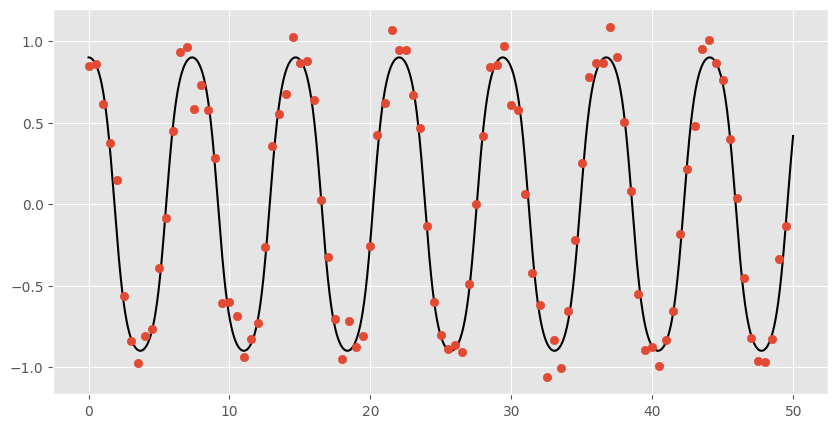

In [51]:
plt.figure(figsize=(10,5))
plt.plot(t_true, X_true[:,0],c='black')
plt.scatter(t_train, X_train[:,0],zorder=2)
plt.show()

In [52]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 1.
colloc_weight = 1e3
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
    beta_reg=1e-2,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
    # num_annealing_steps=3,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0,),
    ode_order=2,
    feature_names=['x']
)



In [53]:
model.fit(
    t = t_train,
    x = X_train[:,0].reshape(-1,1),
    t_colloc=t_colloc
)

{'show_progress': True, 'sigma2_est': Array(0.01493394, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 1000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.756, gradnorm = 4.603, alpha = 4.167, improvement_ratio = 1.003
Iteration 1, loss = 1.288, gradnorm = 1.981, alpha = 3.472, improvement_ratio = 1.004
Iteration 2, loss = 1.051, gradnorm = 1.265, alpha = 2.894, improvement_ratio = 1.002
Iteration 3, loss = 0.9292, gradnorm = 0.8166, alpha = 2.411, improvement_ratio = 1.001
Iteration 4, loss = 0.8664, gradnorm = 0.5318, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.8338, gradnorm = 0.3491, alpha = 1.674, improvement_ratio = 1.0
Iteration 51, loss = 0.7838, gradnorm = 8.782e-09, alpha = 0.001288, improvement_ratio = 1.0
Model after smooth warm start
(x)'' = -0.021 1 + -0.962 x + 0.059 x^2 + 0.321 x^3
Alternating Activeset Sparsifier
2 active coeffs changed
Active set stabilized


In [54]:
model.print()

(x)'' = -0.981 x + 0.347 x^3


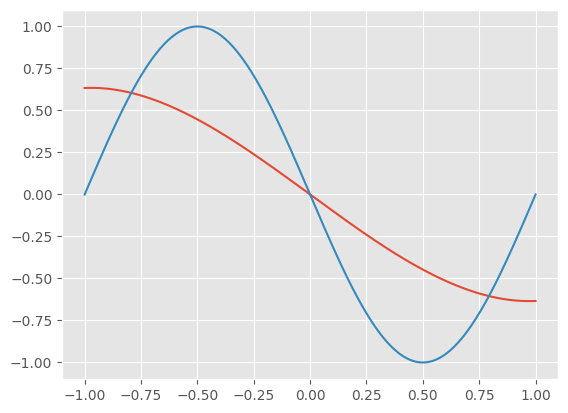

In [55]:
xgrid = jnp.linspace(-1,1,500)

plt.plot(xgrid,model.predict(xgrid[:,None])[:,0])
plt.plot(xgrid,-jnp.sin(jnp.pi*xgrid))

In [56]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 0.000 + 1.00Matern(5,2.38)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 3
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.01,
sparsifier: STLSQ(alpha=0.01, threshold=0.05)
data_weight: 1.0
colloc_weight: 1000.0




## Predict higher order dynamics

In [57]:
ddx_pred = model.predict(X_true[:,:1])

In [58]:
X_true

Array([[ 0.9       ,  0.        ],
       [ 0.89999614, -0.0015451 ],
       [ 0.89998455, -0.00309032],
       ...,
       [ 0.40945459,  0.88550544],
       [ 0.41387011,  0.88069678],
       [ 0.41826153,  0.87586963]], dtype=float64)

In [59]:
ddx_pred

Array([[-0.62974731],
       [-0.62974677],
       [-0.62974518],
       ...,
       [-0.37772076],
       [-0.38127225],
       [-0.3847877 ]], dtype=float64)

In [60]:
-0.7*3 + 0.073* 3**3

-0.12899999999999978

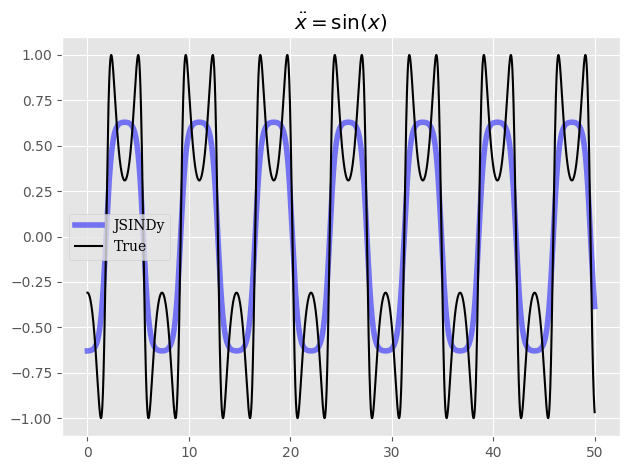

In [61]:
plt.plot(t_true, ddx_pred, c='blue', alpha=0.5, lw=4, label='JSINDy')
plt.plot(t_true, -jnp.sin(jnp.pi*X_true[:,0]), c='black', label="True")
plt.title(r"$\ddot{x} = \sin(x)$", family='serif')
plt.legend(prop={'family':'serif'})
plt.tight_layout()
plt.show()

## State prediction

In [62]:
x_pred = model.predict_state(t_true)

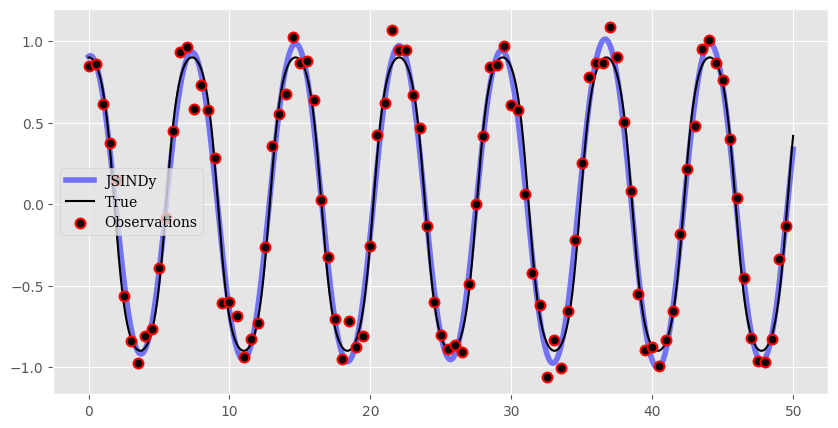

In [63]:
plt.figure(figsize=(10,5))
plt.plot(t_true, x_pred, label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true, X_true[:,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 2, facecolors='black', edgecolors='red', label="Observations", s=50,lw=1.5)
plt.legend(prop={'family':'serif'})
plt.show()

In [64]:
model.predict(X_true)

Array([[ 0.        ],
       [ 0.00136367],
       [ 0.0027274 ],
       ...,
       [-0.33902497],
       [-0.34064363],
       [-0.34219953]], dtype=float64)

## Plot with simulated results

In [65]:
ode_sys = jax.jit(ode_sys)

ode_sys_pred = jax.jit(model.predict)

def model_ode_sys(t, state, args):
    x, dx = state
    # print(dx)
    # print(state)
    # print(ode_sys_pred(state))
    return jnp.array([dx, ode_sys_pred(jnp.array([x]))[0]])


# model_ode_sys = lambda t, x, args: ode_sys_pred(x)

In [66]:
model_ode_sys(None, X_true[-1], None)

Array([ 0.87586963, -0.3847877 ], dtype=float64)

In [67]:
def simulate_sol(y0,system, t0=t0,t1=t1,dt=dt,t_eval =t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)

In [68]:
t_eval = jnp.arange(t0, t1*2, dt)

In [69]:
t_eval[-1]

Array(99.995, dtype=float64)

In [70]:
simulate_times = jnp.linspace(t1,2.*t1,1000)

x_true_extend = simulate_sol(sol.evaluate(t1), system=ode_sys,t_eval=simulate_times,t0 = t1, t1=t1*2)[:,0]
x_model_extend = simulate_sol(sol.evaluate(t1), system=model_ode_sys, t_eval = simulate_times,t0 = t1,t1=t1*2)[:,0]

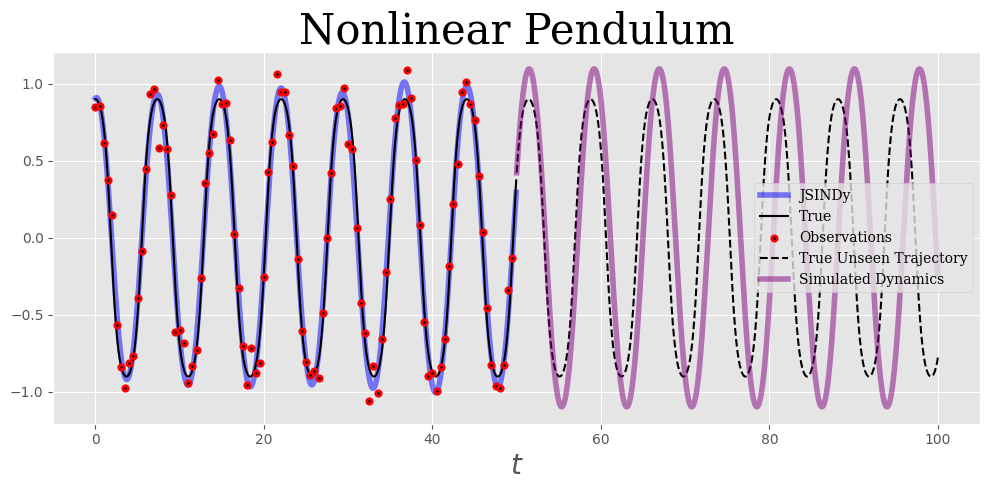

In [71]:
cutoff = -10
plt.figure(figsize=(10,5))
plt.plot(t_true[:cutoff], x_pred[:cutoff], label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true[:cutoff], X_true[:cutoff,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=15,lw=2.)

# extension
# t_extend = t_true + t_true[cutoff]
new_cutoff = len(t_true)# + cutoff

plt.plot(simulate_times, x_true_extend,linestyle="--", c='black', label="True Unseen Trajectory")
plt.plot(simulate_times, x_model_extend, c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)

plt.xlabel(r"$t$",size=20, family='serif')
plt.legend(prop={'family':'serif'},loc='right')
plt.title(r"Nonlinear Pendulum",size=30, family='serif')
plt.tight_layout()
if savefig: 
    plt.savefig("non-linear-pendulum.pdf")
plt.show()

In [72]:
model.print()

(x)'' = -0.981 x + 0.347 x^3


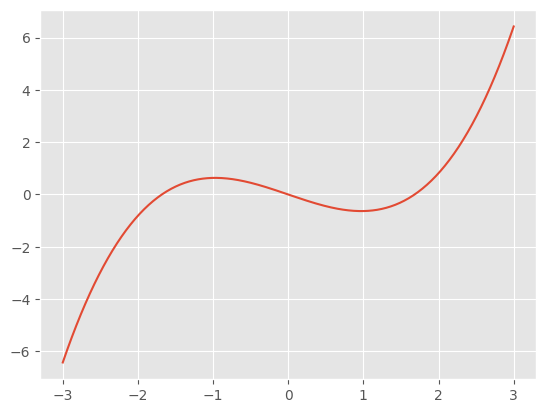

In [73]:
xgrid = jnp.linspace(-3,3,500)

plt.plot(xgrid,model.predict(xgrid[:,None])[:,0])

In [74]:
model.predict(jnp.array([-3]))

Array([-6.42218387], dtype=float64)